<h1><center> Predictive statistics on the I-SPY1 Clinical Trial</center></h1>

### 0. Load modules and clean data

In [1]:
# import custom modules wrote by julio
import pandas as pd
import numpy as np
RANDOM_STATE = 42; # for reproducibility
import matplotlib.pyplot as plt
%matplotlib inline


from ispy1 import predictive_statistics

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics, linear_model 
from imblearn import over_sampling, pipeline 

# reload modules without restartign the kernel (makes development easier)
import importlib
importlib.reload(predictive_statistics);

df = pd.read_csv('./data/I-SPY_1_clean_data.csv')
df.head(2)

,SUBJECTID,age,White,ER+,PR+,HR+,Bilateral,Right_Breast,MRI_LD_Baseline,MRI_LD_1_3dAC,MRI_LD_Int_Reg,MRI_LD_PreSurg,Alive,Survival_length,RFS,RFS_code,PCR,RCB
0,1001,38.73,Yes,Yes,No,Yes,No,No,88.0,78.0,30.0,14.0,No,1264,751,1,No,2.0
1,1002,37.79,Yes,Yes,Yes,Yes,No,Yes,29.0,26.0,66.0,16.0,No,1155,1043,1,No,3.0


<h1><center> Prediction of categorical outcomes</center></h1>

## 1.0 Pathological Complete Response (PCR)

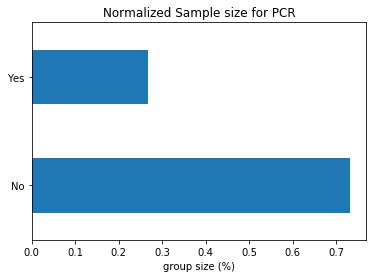

In [2]:
# allocate continous predictors
cont_predictors = ['age','MRI_LD_Baseline', 'MRI_LD_1_3dAC', 'MRI_LD_Int_Reg', 'MRI_LD_PreSurg']
X_cont = df[cont_predictors].values

# allocate clinical predictors
cat_predictors = ['White', 'ER+', 'PR+', 'HR+'];
X_cat = pd.pandas.get_dummies(df[cat_predictors], drop_first=True).values

# allocate a single predictors matrix X
X = np.concatenate( (X_cont, X_cat), axis=1)

# allocate  outcome 
outcome = 'PCR'
y = predictive_statistics.labels_to_numbers(df, outcome);

# check how unbalanced the data are
df[outcome].value_counts(normalize = True).plot.barh();
plt.title('Normalized Sample size for PCR')
plt.xlabel('group size (%)');
plt.savefig('Sample_Size_PCR.png')

In [12]:
def binary_classifier_metrics(classifier, Xtrain, Ytrain, Xtest, Ytest):
    # metrics
    predicted_class = classifier.predict(Xtest)
    kappa = metrics.cohen_kappa_score(Ytest,predicted_class)
    auc = metrics.roc_auc_score(Ytest,predicted_class)
            
    # ROC curve
    probability = classifier.predict_proba(Xtest)
    fpr, tpr, _  = metrics.roc_curve(Ytest, probability[:,1])
    # report 
    print(metrics.classification_report(Ytest,predicted_class))
     
    return np.round(auc,3), np.round(kappa,3), fpr, tpr


# perform Logistic Regression without correcting for unbalance
def LogisticRegression(Xdata, Ydata, oversample = True):
    
    # split data
    X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata, random_state=RANDOM_STATE)
    
    # train and tune parameters using GridSearchCV
    pars= dict(   C = np.arange(.01,100,.1) )
    
    grid =  GridSearchCV(  linear_model.LogisticRegression(), param_grid = pars, 
                           scoring = metrics.make_scorer(metrics.roc_auc_score), 
                           cv= 5, verbose = 0, n_jobs = -1)
        
    # fit
    grid.fit(X_train,y_train)
    
    # metrics
    auc, kappa, fpr, tpr = binary_classifier_metrics(grid, X_train, y_train, X_test, y_test)
    
    # output
    return auc, kappa, fpr, tpr 

# Random Forest Regressor
from sklearn.ensemble import RandomForestClassifier as RFC

def RandomForestClassifier(Xdata, Ydata):
    # split data
    X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata, random_state=RANDOM_STATE)
        
    # define parameter grid search
    pars = dict(    n_estimators = np.arange(5,50,5), 
                    max_features = np.arange(1, X.shape[1], 1),
                    max_depth = [None, 1, 2, 3, 4, 5])
    
    # perform grid search
    grid=  GridSearchCV(RFC( random_state = RANDOM_STATE),param_grid = pars, 
                           scoring = metrics.make_scorer(metrics.roc_auc_score), 
                           cv= 3, verbose = 0, n_jobs = -1)
    
    # fit
    grid.fit(X_train,y_train)
    
    # metrics
    auc, kappa, fpr, tpr = binary_classifier_metrics(grid, X_train, y_train, X_test, y_test)
    
    # output
    return auc, kappa, fpr, tpr 

def plot_compare_roc(fpr1_, tpr1_,fpr2_, tpr2_, auc1, auc2, outcome_legend = ' '):
    plt.plot(fpr1_, tpr1_, fpr2_, tpr2_);
    plt.legend(['Unbalanced | AUC = ' + str(auc1),'Oversampled | AUC = ' + str(auc2)]);
    plt.xlabel('False-positive rate');
    plt.ylabel('True-positive rate');
    plt.title('Effect of oversampling on Logistic Regression for '+ outcome_legend);


In [14]:
# standard
auc1, kappa1, fpr1, tpr1 = LogisticRegression(X, y)
print('The estimated Cohen kappa is ' + str(kappa1))

             precision    recall  f1-score   support

          0       0.76      0.88      0.81        32
          1       0.20      0.10      0.13        10

avg / total       0.62      0.69      0.65        42

The estimated Cohen kappa is -0.03


In [15]:
auc2, kappa2, fpr2, tpr2 = RandomForestClassifier(X, y)
print('The estimated Cohen kappa is ' + str(kappa1))

             precision    recall  f1-score   support

          0       0.78      0.91      0.84        32
          1       0.40      0.20      0.27        10

avg / total       0.69      0.74      0.70        42

The estimated Cohen kappa is -0.03


In [ ]:
# unbalanced learning
ubl = over_sampling.SMOTE(random_state = RANDOM_STATE, k_neighbors = 3)
X_resampled, y_resampled = ubl.fit_sample(X,y)

auc2, kappa2, fpr2, tpr2 = LogisticRegression(X_resampled, y_resampled, scorer = 'auc')
print('The estimated Cohen kappa is ' + str(kappa2))

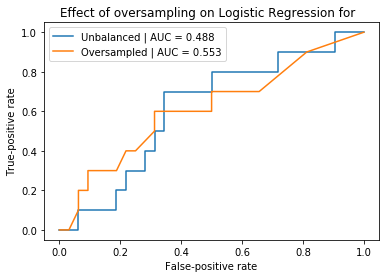

In [16]:
plot_compare_roc(fpr1, tpr1,fpr2, tpr2, auc1, auc2, outcome_legend = ' ')

In [ ]:
plt.plot(fpr1, tpr1,fpr2, tpr2);
plt.legend(['Unbalanced | AUC = ' + str(auc1),'Oversampled | AUC = ' + str(auc2)]);
plt.xlabel('False-positive rate');
plt.ylabel('True-positive rate');
plt.title('Effect of oversampling on Logistic Regression for PCR');
plt.savefig('ROC_curve_PCR.png')

## 2.0 Survival (`Alive`)

In [ ]:
# allocate  outcome 
outcome = 'Alive'
y = predictive_statistics.labels_to_numbers(df, outcome);

# check how unbalanced the data are
df[outcome].value_counts(normalize = True).plot.barh();
plt.title('Normalized Sample size for Alive')
plt.xlabel('group size (%)');
plt.savefig('Sample_Size_Alive.png')

In [ ]:
# standard
auc1, kappa1, fpr1, tpr1 = LogisticRegression(X, y)
print('The estimated Cohen kappa is ' + str(kappa1))

In [ ]:
# oversample
ubl = over_sampling.SMOTE(random_state = RANDOM_STATE, k_neighbors = 10)
#split
X_resampled, y_resampled = ubl.fit_sample(X,y)
#fit
auc2, kappa2, fpr2, tpr2 = LogisticRegression(X_resampled, y_resampled)
print('The estimated Cohen kappa is ' + str(kappa2))

In [ ]:
plt.plot(fpr1, tpr1,fpr2, tpr2);
plt.legend(['Unbalanced | AUC = ' + str(auc1),'Oversampled | AUC = ' + str(auc2)]);
plt.xlabel('False-positive rate');
plt.ylabel('True-positive rate');
plt.title('Effect of oversampling on Logistic Regression for Alive');
plt.savefig('ROC_curve_Alive.png')

## 3.0 Survival (`Alive`) including PCR as predictor

In [ ]:
# allocate new variable
pcr = predictive_statistics.labels_to_numbers(df, 'PCR').reshape(168,1)
newX = np.concatenate((X,pcr), axis  = 1)

In [ ]:
# regular logistic regression
auc1, kappa1, fpr1, tpr1 = LogisticRegression(newX, y, scorer = 'nada')
print('The estimated Cohen kappa is ' + str(kappa2))

In [ ]:
# oversample
ubl = over_sampling.SMOTE(random_state = RANDOM_STATE, k_neighbors = 31)
#split
X_resampled, y_resampled = ubl.fit_sample(newX,y)
#fit
auc2, kappa2, fpr2, tpr2 = LogisticRegression(X_resampled, y_resampled)
print('The estimated Cohen kappa is ' + str(kappa2))

In [ ]:
plt.plot(fpr1, tpr1,fpr2, tpr2);
plt.legend(['Unbalanced | AUC = ' + str(auc1),'Oversampled | AUC = ' + str(auc2)]);
plt.xlabel('False-positive rate');
plt.ylabel('True-positive rate');
plt.title('Effect of oversampling on Logistic Regression for Alive + PCR predicotr');
plt.savefig('ROC_curve_Alive_plus_PCR.png')

## 4.0 Survival (`Alive`) including `RCB` as predictor

In [ ]:
rcb = pd.get_dummies(df['RCB']).values
newX = np.concatenate((X,rcb), axis  = 1)
newX = X_cont[:,1:4]
newX

In [ ]:
# regular logistic regression
auc1, kappa1, fpr1, tpr1 = LogisticRegression(newX, y)
print('The estimated Cohen kappa is ' + str(kappa2))

In [ ]:
# oversample
ubl = over_sampling.SMOTE(random_state = RANDOM_STATE, k_neighbors = 31)
#split
X_resampled, y_resampled = ubl.fit_sample(newX,y)
#fit
auc2, kappa2, fpr2, tpr2 = LogisticRegression(X_resampled, y_resampled)
print('The estimated Cohen kappa is ' + str(kappa2))

In [ ]:
plt.plot(fpr1, tpr1,fpr2, tpr2);
plt.legend(['Unbalanced | AUC = ' + str(auc1),'Oversampled | AUC = ' + str(auc2)]);
plt.xlabel('False-positive rate');
plt.ylabel('True-positive rate');
plt.title('Effect of oversampling on Logistic Regression for Alive');

In [ ]:
X

In [ ]:
y

In [ ]:
X_resampled[X_resampled < 0]


In [ ]:
import seaborn.apionly as sns 
from sklearn import feature_selection

# allocate  outcome 
outcome = 'Alive'
y = predictive_statistics.labels_to_numbers(df, outcome);
predictor_list = cont_predictors + cat_predictors

# over sapmple
ubl = over_sampling.SMOTE(random_state = RANDOM_STATE, k_neighbors = 3)
X_resampled, y_resampled = ubl.fit_sample( X,y)

# chi-square
chi2, pval = feature_selection.chi2(X_resampled, y_resampled)

plt.barh(range(1,len(chi2)+1),pval);
plt.yticks(range(1,len(chi2)+1), predictor_list);

In [ ]:
import seaborn.apionly as sns 
from sklearn import feature_selection

# allocate  outcome 
outcome = 'Alive'
y = predictive_statistics.labels_to_numbers(df, outcome);
l = cont_predictors + cat_predictors

# over sapmple
ubl = over_sampling.SMOTE(random_state = RANDOM_STATE, k_neighbors = 3)
X_resampled, y_resampled = ubl.fit_sample(X,y)

# chi-square
chi2, pval = feature_selection.chi2(X_resampled, y_resampled)
plt.barh(range(1,10),chi2);
plt.yticks(range(1,10), l);

In [ ]:
yn= predictive_statistics.labels_to_numbers(df, 'PCR').reshape(168,1)
X_with_pcr = np.concatenate( (X,yn), axis = 1)
X_resampled, y_resampled = ubl.fit_sample(X_with_pcr,y)
# chi-square
chi2, pval = feature_selection.chi2(X_resampled, y_resampled)
plt.barh(range(1,11),chi2);
plt.yticks(range(1,11), l + ['PCR']);

<h1><center> Prediction of continous outcomes</center></h1>

## Prepare functions

In [ ]:
# metrics
mae = metrics.median_absolute_error

def mae_report(Ytest, Yhat, outcome_):
    error = mae(Ytest, Yhat)
    error = np.round( error, decimals=3)
    # report
    print('\n' )
    print('==' *40)
    print('The median absolute error for testing data set of ' + outcome_ + ' is: ' + str(error))
    print('==' *40)

def train_test_report(predictor, Xtrain, Ytrain, Xtest, Ytest, outcome):
    # train
    predictor.fit(Xtrain, Ytrain)
    # test
    Yhat = predictor.predict(Xtest)
    # report
    mae_report(Ytest, Yhat, outcome)
    
# lsq 
import statsmodels.api as sm
def lsq(Xtrain,Ytrain, Xtest, Ytest, outcome =''):
    # train
    OLS = sm.OLS(Ytrain,Xtrain).fit();
    print(OLS.summary())
    #test
    Yhat = OLS.predict(Xtest)
    # report
    mae_report(Ytest, Yhat, outcome)

# SVR    
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV   

# GridSearchCV utility
def gridsearch(regressor, grid):
    optimized_regressor=  GridSearchCV(  regressor, 
                               param_grid = grid, 
                               cv= 3, verbose = 0, n_jobs = -1,
                               scoring = metrics.make_scorer(metrics.median_absolute_error))
    
    return optimized_regressor
    


def svr(Xtrain,Ytrain, Xtest, Ytest, outcome = ''):
    # define regressor
    regressor =  SVR()
    # define parameter grid search
    grid = dict(       kernel = ['rbf','linear','sigmoid'], 
                       C = np.arange(1,11,1),
                       epsilon = np.arange(1,11,1),
                       gamma = np.linspace(1/10,10,3))
    # perform grid search
    grid_search=  gridsearch(regressor, grid)
    
    # train, test, and report
    train_test_report(grid_search, Xtrain, Ytrain, Xtest, Ytest, outcome)

    
# ElasticNet
from sklearn.linear_model import ElasticNet as ENet

def ElasticNet(Xtrain,Ytrain, Xtest, Ytest, outcome = ''):
    # define regressor
    regressor =  ENet(max_iter=5000)
    # define parameter grid search
    grid = dict(   alpha = np.arange(1,20,.5), l1_ratio = np.arange(.1,1,.05))
    # perform grid search
    grid_search=  gridsearch(regressor, grid)
    # train, test, and report
    train_test_report(grid_search, Xtrain, Ytrain, Xtest, Ytest, outcome)
    

# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor as RFR

def RandomForestRegressor(Xtrain,Ytrain, Xtest, Ytest, outcome = ''):
    # define regressor
    regressor =  RFR( criterion='mse', random_state = RANDOM_STATE)
    
    #
    num_features = Xtrain.shape[1]
    
    # define parameter grid search
    grid = dict(    n_estimators = np.arange(5,100,5), 
                    max_features = np.arange(1,num_features, 1),
                    max_depth = [None, 1, 2, 3, 4, 5])
    
    # perform grid search
    grid_search=  gridsearch(regressor, grid)
    
    # train, test, and report
    train_test_report(grid_search, Xtrain, Ytrain, Xtest, Ytest, outcome)
    

## Organize predictors in the right format and split data

In [ ]:
# allocate continous predictors
cont_predictors = ['age','MRI_LD_Baseline', 'MRI_LD_1_3dAC', 'MRI_LD_Int_Reg', 'MRI_LD_PreSurg']
contX = df[cont_predictors].values

# allocate categorical predictors
cat_pred = ['PCR','White', 'ER+', 'PR+', 'HR+'];
catX = pd.pandas.get_dummies(df[cat_pred], drop_first=True).values

# concatenate predictors
X = np.concatenate( (catX, contX), axis=1)

#outcome
y = df.RFS.values / 30; # conver to months

#split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

## 1.0 Recurrence-Free Survival (`RFS`, Continous in months)

In [ ]:
# LSQ
lsq(X_train, y_train, X_test, y_test, outcome =' Recurrence-Free Survival (months)')

### Categorical Predictors only Linear Regression

## ElasticNet

In [ ]:
ElasticNet(X_train, y_train, X_test, y_test, outcome =' Recurrence-Free Survival (months)')

## SVM Regressor

In [ ]:
svr(X_train, y_train, X_test, y_test, outcome =' Recurrence-Free Survival (months)')

## Random Fores regressor

In [ ]:
RandomForestRegressor(X_train, y_train, X_test, y_test, outcome =' Recurrence-Free Survival (months)')

## 2.0  Survival Length (`Survival_length`, Continous, months)

In [ ]:
y = df.Survival_length.values / 30
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

In [ ]:
# # LSQ
lsq(X_train, y_train, X_test, y_test, outcome ='Survival_length (months)')

In [ ]:
svr(X_train, y_train, X_test, y_test, outcome ='Survival length (months)')

In [ ]:
ElasticNet(X_train, y_train, X_test, y_test, outcome = 'Survival length (months)')